<a href="https://colab.research.google.com/github/Maxoo005/ml-wakacyjne-wyzwanie-2025/blob/main/3MaksymilianKula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [14]:
import os, time, copy, random, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

torch.set_printoptions(precision=4, linewidth=120)
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass

Ustawienia i powtarzalnosc

In [15]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else torch.device("cpu")
)
DEVICE

device(type='cpu')

In [16]:
BATCH_SIZE = 128
NUM_WORKERS = 2
NUM_EPOCHS = 15
PATIENCE = 4
BASE_LR = 1e-3
WEIGHT_DECAY = 1e-4

Fast Mode, dla uzyskania szybkiego przebiegu by ją wyłączyc trzeba ustawic Flase

In [17]:
FAST_MODE = True
FAST_TRAIN_SAMPLES = 5000
FAST_VAL_SAMPLES   = 1000
FAST_TEST_SAMPLES  = 2000
FAST_EPOCHS = 5

Dane MNIST(train/val/test) i podgląd jednej próbki

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainval_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds     = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

val_size = 10000
train_size = len(trainval_ds) - val_size
gen = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(trainval_ds, [train_size, val_size], generator=gen)

if FAST_MODE:
    rng = np.random.default_rng(SEED)
    train_idx = rng.choice(len(train_ds), size=min(FAST_TRAIN_SAMPLES, len(train_ds)), replace=False)
    val_idx   = rng.choice(len(val_ds),   size=min(FAST_VAL_SAMPLES,   len(val_ds)),   replace=False)
    test_idx  = rng.choice(len(test_ds),  size=min(FAST_TEST_SAMPLES,  len(test_ds)),  replace=False)
    train_ds = Subset(train_ds, train_idx)
    val_ds   = Subset(val_ds,   val_idx)
    test_ds  = Subset(test_ds,  test_idx)

pin = (DEVICE.type == "cuda")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin)

x0, y0 = next(iter(train_loader))
print("batch shape:", x0.shape, "labels:", y0[:8].tolist())


batch shape: torch.Size([128, 1, 28, 28]) labels: [7, 6, 8, 3, 6, 2, 8, 4]


Modele Softmax, MLP, CNN

In [20]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class SoftmaxRegression(nn.Module):
    def __init__(self, in_dim=28*28, n_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, n_classes)
        )
    def forward(self, x):
        return self.net(x)

class MLP(nn.Module):
    def __init__(self, hidden=256, dropout=0.3, in_dim=28*28, n_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, x):
        return self.net(x)

def make_cnn(base_channels=32, depth=2, use_bn=True, dropout=0.3, n_classes=10):
    layers = []
    in_ch = 1
    ch = base_channels
    for i in range(depth):
        layers.append(nn.Conv2d(in_ch, ch, kernel_size=3, padding=1, bias=not use_bn))
        if use_bn:
            layers.append(nn.BatchNorm2d(ch))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        in_ch = ch
        ch = ch * 2
    feature_extractor = nn.Sequential(*layers)
    classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(in_ch, n_classes)
    )
    return nn.Sequential(feature_extractor, classifier)


Metryki, pętle trenigowe, EarlyStopping by zatrzymac trening w momecie overfitting`u

In [29]:
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion, device=DEVICE, return_predictions=False):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    y_true_all, y_pred_all = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_count += x.size(0)
        y_true_all.append(y.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    acc = total_correct / total_count
    f1_macro = f1_score(y_true_all, y_pred_all, average='macro')
    if return_predictions:
        return total_loss / total_count, acc, f1_macro, (y_true_all, y_pred_all)
    return total_loss / total_count, acc, f1_macro

def train_one_epoch(model, loader, optimizer, criterion, device=DEVICE, clip_grad_norm=None):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        optimizer.step()
        preds = logits.argmax(dim=1)
        running_loss += loss.item() * x.size(0)
        running_correct += (preds == y).sum().item()
        running_count += x.size(0)
    return running_loss / running_count, running_correct / running_count

class EarlyStopping:
    def __init__(self, patience=5, mode='max', min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best_score = None
        self.num_bad = 0
        self.best_state = None

    def step(self, metric, model):
        score = metric if self.mode == 'max' else -metric
        if self.best_score is None or score > self.best_score + self.min_delta:
            self.best_score = score
            self.num_bad = 0
            self.best_state = copy.deepcopy(model.state_dict())
            return False
        else:
            self.num_bad += 1
            return self.num_bad > self.patience


In [30]:
def n_params(model):
    return sum(p.numel() for p in model.parameters())

def run_experiment(
    name, model_fn, optimizer_name='adam', lr=BASE_LR, weight_decay=WEIGHT_DECAY,
    scheduler_name='plateau', epochs=NUM_EPOCHS, model_init_kwargs=None
):
    model_init_kwargs = model_init_kwargs or {}
    model = model_fn(**model_init_kwargs).to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    if scheduler_name == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    else:
        scheduler = None

    early = EarlyStopping(patience=PATIENCE, mode='max')

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_epoch, best_val_metric = -1, -1.0

    for epoch in range(epochs if not FAST_MODE else FAST_EPOCHS):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device=DEVICE, clip_grad_norm=1.0)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device=DEVICE)

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        if scheduler is not None:
            scheduler.step(val_acc)

        stop = early.step(val_acc, model)
        if val_acc > best_val_metric:
            best_val_metric = val_acc
            best_epoch = epoch

        dt = time.time() - t0
        print(f"[{name}] epoch {epoch+1:02d}/{epochs if not FAST_MODE else FAST_EPOCHS} "
              f"train_loss={tr_loss:.4f} val_loss={val_loss:.4f} "
              f"train_acc={tr_acc:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} "
              f"lr={optimizer.param_groups[0]['lr']:.2e} ({dt:.1f}s)")

        if stop:
            print(f"[{name}] Early stopping (best epoch: {best_epoch+1})")
            break

    if early.best_state is not None:
        model.load_state_dict(early.best_state)

    test_loss, test_acc, test_f1, (y_true, y_pred) = evaluate(model, test_loader, criterion, device=DEVICE, return_predictions=True)
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    result = {
        'name': name,
        'params': n_params(model),
        'opt': optimizer_name,
        'lr': lr,
        'wd': weight_decay,
        'epochs_run': len(history['train_loss']),
        'best_epoch': best_epoch,
        'val_acc': max(history['val_acc']) if len(history['val_acc']) else float('nan'),
        'val_f1':  max(history['val_f1']) if len(history['val_f1']) else float('nan'),
        'test_acc': test_acc,
        'test_f1': test_f1,
        'history': history,
        'model': model,
        'classification_report': report,
        'confusion_matrix': cm
    }
    return result

Lista eksperymentów
Dwie Bazy:
1.   Baseline (softmax, MLP)
2.   CNN (różne szerokości/głębokośći, BN/Dropout)



In [31]:
experiments = []

experiments.append(dict(
    name="softmax_sgd",
    model_fn=SoftmaxRegression, optimizer_name='sgd', lr=1e-1, weight_decay=0.0,
    model_init_kwargs={}
))
experiments.append(dict(
    name="softmax_adam",
    model_fn=SoftmaxRegression, optimizer_name='adam', lr=1e-3, weight_decay=0.0,
    model_init_kwargs={}
))

for hidden in [128, 256]:
    for dp in [0.0, 0.3]:
        experiments.append(dict(
            name=f"mlp_h{hidden}_dp{dp}",
            model_fn=MLP, optimizer_name='adam', lr=1e-3, weight_decay=1e-4,
            model_init_kwargs=dict(hidden=hidden, dropout=dp)
        ))

for depth in [2, 3]:
    for base_ch in [16, 32]:
        for dp in [0.0, 0.3]:
            for bn in [True, False]:
                experiments.append(dict(
                    name=f"cnn_d{depth}_c{base_ch}_dp{dp}_bn{int(bn)}",
                    model_fn=make_cnn, optimizer_name='adam', lr=1e-3, weight_decay=1e-4,
                    model_init_kwargs=dict(base_channels=base_ch, depth=depth, use_bn=bn, dropout=dp)
                ))

len(experiments)

22

Uruchomienie eksperymentów

In [32]:
results = []
for exp in experiments:
    res = run_experiment(**exp)
    results.append(res)

[softmax_sgd] epoch 01/5 train_loss=0.7580 val_loss=0.4830 train_acc=0.7802 val_acc=0.8770 val_f1=0.8706 lr=1.00e-01 (1.7s)
[softmax_sgd] epoch 02/5 train_loss=0.4712 val_loss=0.5862 train_acc=0.8780 val_acc=0.8630 val_f1=0.8550 lr=1.00e-01 (1.7s)
[softmax_sgd] epoch 03/5 train_loss=0.3991 val_loss=0.4967 train_acc=0.8956 val_acc=0.8890 val_f1=0.8837 lr=1.00e-01 (2.5s)
[softmax_sgd] epoch 04/5 train_loss=0.3796 val_loss=0.6029 train_acc=0.9020 val_acc=0.8560 val_f1=0.8446 lr=1.00e-01 (1.7s)
[softmax_sgd] epoch 05/5 train_loss=0.3748 val_loss=0.6746 train_acc=0.9034 val_acc=0.8550 val_f1=0.8482 lr=1.00e-01 (1.6s)
[softmax_adam] epoch 01/5 train_loss=1.1029 val_loss=0.5431 train_acc=0.6856 val_acc=0.8590 val_f1=0.8539 lr=1.00e-03 (1.7s)
[softmax_adam] epoch 02/5 train_loss=0.4803 val_loss=0.4073 train_acc=0.8700 val_acc=0.8840 val_f1=0.8799 lr=1.00e-03 (1.6s)
[softmax_adam] epoch 03/5 train_loss=0.3871 val_loss=0.3728 train_acc=0.8976 val_acc=0.9000 val_f1=0.8968 lr=1.00e-03 (1.6s)
[soft

Tablela porównawcza wyników

In [33]:
summary_rows = []
for r in results:
    row = {
        'name': r['name'],
        'params': r['params'],
        'val_acc': r['val_acc'],
        'val_f1': r['val_f1'],
        'test_acc': r['test_acc'],
        'test_f1': r['test_f1'],
        'epochs_run': r['epochs_run'],
        'best_epoch': r['best_epoch'],
        'opt': r['opt'],
        'lr': r['lr'],
        'wd': r['wd']
    }
    summary_rows.append(row)

df = pd.DataFrame(summary_rows).sort_values(['val_acc','test_acc'], ascending=False).reset_index(drop=True)
df.head(20)

,name,params,val_acc,val_f1,test_acc,test_f1,epochs_run,best_epoch,opt,lr,wd
0,cnn_d3_c32_dp0.3_bn1,94186,0.968,0.967654,0.9605,0.960340,5,3,adam,0.001,0.0001
1,cnn_d3_c32_dp0.0_bn1,94186,0.955,0.953728,0.9605,0.960025,5,3,adam,0.001,0.0001
2,cnn_d3_c16_dp0.0_bn1,24058,0.944,0.943034,0.9390,0.938075,5,4,adam,0.001,0.0001
3,mlp_h256_dp0.3,203530,0.939,0.937872,0.9285,0.927121,5,4,adam,0.001,0.0001
4,cnn_d3_c16_dp0.3_bn1,24058,0.933,0.933266,0.9375,0.937572,5,4,adam,0.001,0.0001
5,cnn_d3_c32_dp0.0_bn0,93962,0.931,0.929897,0.9255,0.923131,5,4,adam,0.001,0.0001
6,mlp_h256_dp0.0,203530,0.931,0.930181,0.9110,0.909047,5,3,adam,0.001,0.0001
7,mlp_h128_dp0.3,101770,0.928,0.926525,0.9225,0.920893,5,4,adam,0.001,0.0001
8,cnn_d3_c32_dp0.3_bn0,93962,0.926,0.923730,0.9180,0.916901,5,4,adam,0.001,0.0001
9,mlp_h128_dp0.0,101770,0.926,0.923682,0.9080,0.905864,5,4,adam,0.001,0.0001


Wykres przebiegu i macierz pomyłek dla najlepszego modelu

== Najlepszy eksperyment ==
cnn_d3_c32_dp0.3_bn1 | paramów: 94186


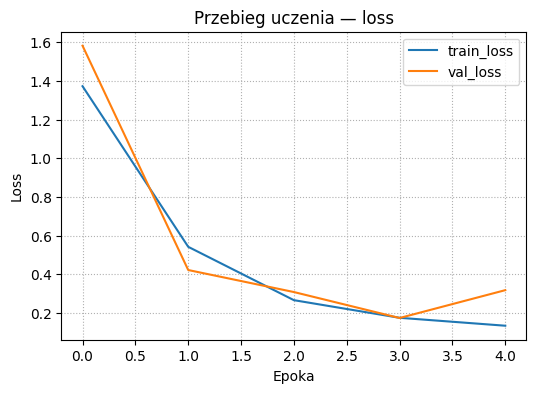

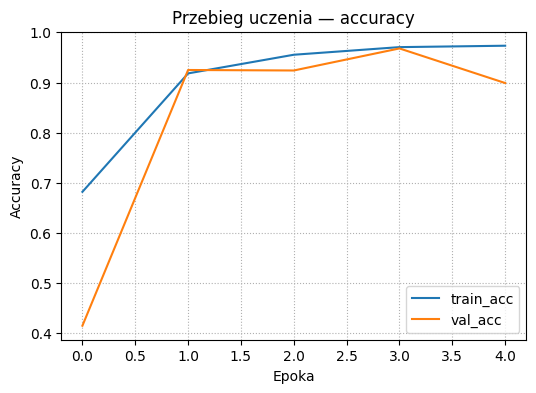

==Classification report (test) ==
              precision    recall  f1-score   support

           0     0.9483    0.9910    0.9692       222
           1     0.9821    0.9955    0.9887       220
           2     0.9950    0.9571    0.9757       210
           3     0.9421    0.9944    0.9676       180
           4     0.8800    0.9900    0.9318       200
           5     0.9936    0.9337    0.9627       166
           6     0.9670    0.9778    0.9724       180
           7     0.9720    0.9541    0.9630       218
           8     0.9725    0.9171    0.9440       193
           9     0.9691    0.8910    0.9284       211

    accuracy                         0.9605      2000
   macro avg     0.9622    0.9602    0.9603      2000
weighted avg     0.9621    0.9605    0.9605      2000



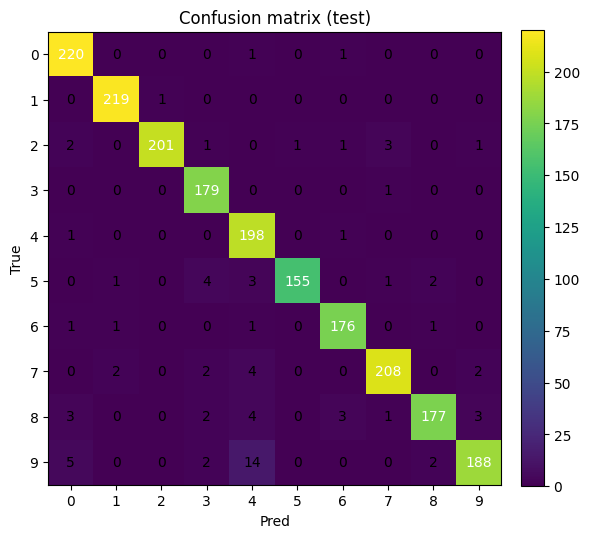

In [34]:
best = results[np.argmax([r['val_acc'] for r in results])]

print("== Najlepszy eksperyment ==")
print(best['name'], "| paramów:", best['params'])
hist = best['history']

plt.figure(figsize=(6,4))
plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.xlabel('Epoka'); plt.ylabel('Loss'); plt.title('Przebieg uczenia — loss'); plt.legend(); plt.grid(True, ls=':')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist['train_acc'], label='train_acc')
plt.plot(hist['val_acc'], label='val_acc')
plt.xlabel('Epoka'); plt.ylabel('Accuracy'); plt.title('Przebieg uczenia — accuracy'); plt.legend(); plt.grid(True, ls=':')
plt.show()

print("==Classification report (test) ==")
print(best['classification_report'])

cm = best['confusion_matrix']
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion matrix (test)')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xlabel("Pred"); ax.set_ylabel("True")
th = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > th else "black")
plt.tight_layout()
plt.show()

Wnioski
*   Baseline dał punkt odniesienia, widac o ile kazda zmiana architektury poprawia sie luub pogarsza wynik wzgledem prostej sieci
*   BatchNorm ustabilizowal uczeie i podnosil metryki
*   Dropout ograniczyl przeuczenie
*   Metryki samo acc bywa mylace ale dodanie precision i F1 pokazuje balans miedzy trafieniami i pomylkami
*   Ustawienie seedow i zapisywanie konfiguracji ulatwia powtarzalne porownania
*   Wygrywa najmnijeszy model spelniajacy cel jaokosci



